#### Import Libraries

In [1]:
import os
from random import sample
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import gridspec
from StructureDataModule import structure_data

In [17]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.initializers import GlorotNormal, GlorotUniform
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

#### Structuring data files

In [3]:
structure_data()

Files moved succesfully!


#### Image Preprocessing

In [4]:
trainset_path = './input/train_set'
valset_path = './input/validation_set'
testset_path = './input/test_set'

(384, 512, 3)


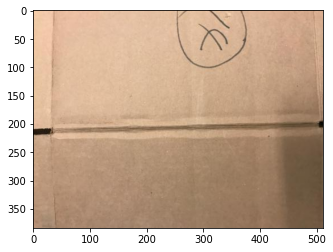

In [5]:
test_img = plt.imread('./input/train_set/cardboard/cardboard1.jpg')
print(test_img.shape)
plt.imshow(test_img)

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    trainset_path,
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1768 images belonging to 6 classes.


In [7]:
val_datagen = ImageDataGenerator(
    rescale = 1/255.
)

val_generator = val_datagen.flow_from_directory(
    valset_path,
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 328 images belonging to 6 classes.


### CNN Model

##### Callbacks

In [18]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.85):
            print("\nReached 85% accuracy so cancelling training!")
            self.model.stop_training = True

In [19]:
stop_cb = myCallback()

In [20]:
checkpoint_path = './checkpoints/cnn_cp_{epoch:04d}.ckpt'

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_mse',
                                                 save_freq=5 * 250,
                                                 #default to epoch, if not how many batches later should it be saved
                                                 verbose=1)


##### Model

In [22]:
model = Sequential([
     Conv2D(filters = 32, kernel_size = (3,3), input_shape = (64,64,3), activation = 'relu', kernel_initializer = GlorotUniform())
    ,MaxPool2D(pool_size = (2,2))
    ,Dropout(0.2)
    ,Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', kernel_initializer = GlorotUniform())
    ,MaxPool2D(pool_size = (2,2))
    ,Dropout(0.2)
    ,Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', kernel_initializer = GlorotUniform())
    ,MaxPool2D(pool_size = (2,2))
    ,Dropout(0.2)
    ,Flatten()
    ,Dense(units = 128, activation = 'relu', kernel_initializer = GlorotUniform())
    ,Dense(units = 256, activation = 'relu', kernel_initializer = GlorotUniform())
    ,Dense(units = 6, activation = 'softmax')
])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 128)      

In [24]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [25]:
%%time
history = model.fit(
     x = train_generator
    ,epochs = 20
    ,validation_data = val_generator
    ,callbacks = [stop_cb]
)

Epoch 1/20
56/56 [==============================] - 11s 138ms/step - loss: 1.7436 - accuracy: 0.2204 - val_loss: 1.6180 - val_accuracy: 0.2866
Epoch 2/20
56/56 [==============================] - 7s 124ms/step - loss: 1.5508 - accuracy: 0.3409 - val_loss: 1.4977 - val_accuracy: 0.3445
Epoch 3/20
56/56 [==============================] - 7s 126ms/step - loss: 1.4244 - accuracy: 0.4370 - val_loss: 1.4100 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 8s 138ms/step - loss: 1.3312 - accuracy: 0.4497 - val_loss: 1.2949 - val_accuracy: 0.5030
Epoch 5/20
56/56 [==============================] - 7s 132ms/step - loss: 1.2998 - accuracy: 0.4841 - val_loss: 1.3130 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 7s 124ms/step - loss: 1.2026 - accuracy: 0.5215 - val_loss: 1.2870 - val_accuracy: 0.5274
Epoch 7/20
56/56 [==============================] - 7s 125ms/step - loss: 1.1633 - accuracy: 0.5415 - val_loss: 1.2227 - val_accuracy: 0.5549
Epoch

#### Plotting ConvLayers Activations

In [ ]:
def getImgSamples(path, n = 1):
    imgs = dict()
    for img_class in os.listdir(path):
        class_path = os.path.join(path, img_class)
        imgs[img_class]  = sample(os.listdir(class_path), n)
    
    return imgs

In [ ]:
def plotSampleImgs(imgs):
    fig, axs = plt.subplots(nrows = 1, ncols = 6, figsize = (24,24))
    col = 0
    for img_class, img_name in imgs.items():
        img_path = os.path.join(testset_path, img_class, img_name[0])
        img = load_img(img_path, target_size = (128,128))
        axs[col].imshow(img)
        axs[col].set_title('{}'.format(img_class))
        col += 1
        
    plt.subplots_adjust(wspace=1.3, hspace=1.3)
    plt.show()
    return

In [ ]:
sample_imgs = getImgSamples(testset_path, 1)
sample_imgs

In [ ]:
plotSampleImgs(sample_imgs)

In [ ]:
def plotFeaturesMaps(model, path, img_class, imgs):

    #Get convolution and pooling layers to plot
    names = [layer.name for layer in model.layers if ('conv' in layer.name)]
    outputs = [layer.output for layer in model.layers if ('conv' in layer.name)]
    
    # redefine model to output right after the first hidden layer
    feature_map_model = Model(inputs = model.inputs, outputs = outputs)
    
    #Get and prepare the image
    img_path = os.path.join(path, img_class, imgs[img_class][0])
    img = load_img(img_path, target_size=(64,64))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    
    #Get feature maps(activations)
    feature_maps = feature_map_model.predict(img)
    
    for layer_name, feature_map in zip(names, feature_maps):    
        k = feature_map.shape[-1] #number of filters applied on the layer
        nrow = k//8
        ncol = 8
        
        fig = plt.figure(figsize=(ncol+1, nrow+1)) 
        gs = gridspec.GridSpec(nrow, ncol,
                 wspace=0.0, hspace=0.0, 
                 top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
                 left=0.5/(ncol+1), right=1-0.5/(ncol+1))  

        for i in range(nrow):
            for j in range(ncol):
                feature_img = feature_map[0, :, :, i]
                ax = plt.subplot(gs[i,j])
                ax.imshow(feature_img)
                ax.set_xticks([])
                ax.set_yticks([])

        #gs.title('Layer {}: {}'.format(i, layer_name))     
        print('Layer {}: {}'.format(i, layer_name)) 
        plt.show()
            
    return

In [ ]:
plotFeaturesMaps(model, testset_path, 'trash', sample_imgs)